In [1]:
#  Load the cleaned data
diabetes_cleaned = pd.read_csv('/workspaces/SP25-Project/data/diabetes_cleaned.csv')


NameError: name 'pd' is not defined

In [ ]:
# Import libraries 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score


In [ ]:
# Define Helper Functions 

def calc_prevalence(y_actual):
    '''
    Calculate prevalence of positive class (1's).
    '''
    return (sum(y_actual) / len(y_actual))

def calc_specificity(y_actual, y_pred_probs, thresh):
    '''
    Calculate specificity: TN / (TN + FP)
    '''
    return sum((y_pred_probs < thresh) & (y_actual == 0)) / sum(y_actual == 0)

def print_report(y_actual, y_pred_probs, thresh=0.5):
    '''
    Calculate and print classification metrics.
    '''
    auc = roc_auc_score(y_actual, y_pred_probs)
    accuracy = accuracy_score(y_actual, (y_pred_probs > thresh))
    recall = recall_score(y_actual, (y_pred_probs > thresh))
    precision = precision_score(y_actual, (y_pred_probs > thresh))
    specificity = calc_specificity(y_actual, y_pred_probs, thresh)

    print(f"AUC: {auc:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Recall (Sensitivity): {recall:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print(f"Prevalence: {calc_prevalence(y_actual):.3f}")
    print(' ')
    
    return auc, accuracy, recall, precision, specificity


In [ ]:
# Remove 'Unknown/Invalid' from gender
diabetes_cleaned = diabetes_cleaned[diabetes_cleaned['gender'] != 'Unknown/Invalid']


In [ ]:
#Define Features (X) and Target (y)

feature_cols = [
    'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
    'num_procedures', 'num_medications', 'number_outpatient',
    'number_emergency', 'number_inpatient', 'number_diagnoses',
    'max_glu_serum_binary', 'A1Cresult_binary',
    'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other'
]

# Features and Target
X = diabetes_cleaned[feature_cols]
y = diabetes_cleaned['readmitted_binary']


In [ ]:
#Split into Train and Validation Sets

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
#Manually Balance the Training Data

# Find positive and negative examples
rows_pos = y_train == 1
df_train_pos = X_train.loc[rows_pos]
df_train_neg = X_train.loc[~rows_pos]

# Undersample the majority class
df_train_neg_bal = df_train_neg.sample(n=len(df_train_pos), random_state=111)

# Combine positive and undersampled negative samples
X_train_balanced = pd.concat([df_train_pos, df_train_neg_bal], axis=0)
y_train_balanced = np.concatenate([np.ones(len(df_train_pos)), np.zeros(len(df_train_pos))])

# Shuffle the training set
X_train_balanced = X_train_balanced.sample(n=len(X_train_balanced), random_state=42).reset_index(drop=True)
y_train_balanced = pd.Series(y_train_balanced).sample(frac=1, random_state=42).reset_index(drop=True)

# Check prevalence
print('Training Balanced Prevalence (n = %d): %.3f' % (len(y_train_balanced), calc_prevalence(y_train_balanced)))


Training Balanced Prevalence (n = 18172): 0.500


In [ ]:
#Train Logistic Regression Model

lr_model = LogisticRegression(random_state=42, solver='newton-cg', max_iter=200)
lr_model.fit(X_train_balanced, y_train_balanced)


LogisticRegression(max_iter=200, random_state=42, solver='newton-cg')

In [ ]:
# Predict Probabilities on Validation Set

y_valid_preds = lr_model.predict_proba(X_valid)[:, 1]


In [ ]:
# Evaluate the Model

print('Metrics for Validation Data:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, lr_valid_precision, lr_valid_specificity = print_report(
    y_valid, y_valid_preds, thresh=0.5
)


Metrics for Validation Data:
AUC: 0.640
Accuracy: 0.677
Recall (Sensitivity): 0.488
Precision: 0.170
Specificity: 0.701
Prevalence: 0.112
 


# Metric Explanations

## 1. AUC = 0.640
- Measures the model’s ability to distinguish between classes.
- 0.5 = random guessing, 1.0 = perfect prediction.
- 0.64 indicates **modest predictive power**, better than random.

## 2. Accuracy = 0.677
- About **68%** of all predictions were correct overall.
- **Accuracy alone can be misleading** in imbalanced datasets (only 11% positives).

## 3. Recall (Sensitivity) = 0.488
- **49%** of true readmissions were correctly identified.
- **Higher recall is important** in healthcare to avoid missing high-risk patients.

## 4. Precision = 0.170
- Only **17%** of patients predicted as readmitted actually were.
- Indicates many **false positives**, but acceptable if the goal is to **catch more real cases**.

## 5. Specificity = 0.701
- About **70%** of non-readmitted patients were correctly classified.
- Good control of false positives for non-readmissions.

## 6. Prevalence = 0.112
- Only **11%** of patients were truly readmitted.
- Indicates the **dataset is highly imbalanced**.

---

# Overall Interpretation
- The model **moderately distinguishes** between readmissions and non-readmissions.
- **Recall** is the priority: catching nearly half of readmissions (0.488) is a reasonable first result.
- **Precision is low** due to dataset imbalance and aggressive catching of potential readmissions.
- **AUC of 0.64** shows modest but real prediction skill above random guessing.
- Imbalanced data makes the task harder and calls for cautious model interpretation.

---

# Potential Improvements
- Lower the classification threshold to 0.3 to **increase Recall** (catch more readmissions).
- Train stronger models like **Random Forest** or **XGBoost**.
- Tune model hyperparameters (e.g., adjust regularization).
- Add new clinical features to improve model learning.
- Use SMOTE or other techniques to balance the training data better.


/tmp/ipykernel_47834/534487127.py:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  diabetes_cleaned = pd.read_csv('/workspaces/SP25-Project/data/diabetes_cleaned.csv')


Intercept: 0.0886
Coefficient (Age effect): 0.0003


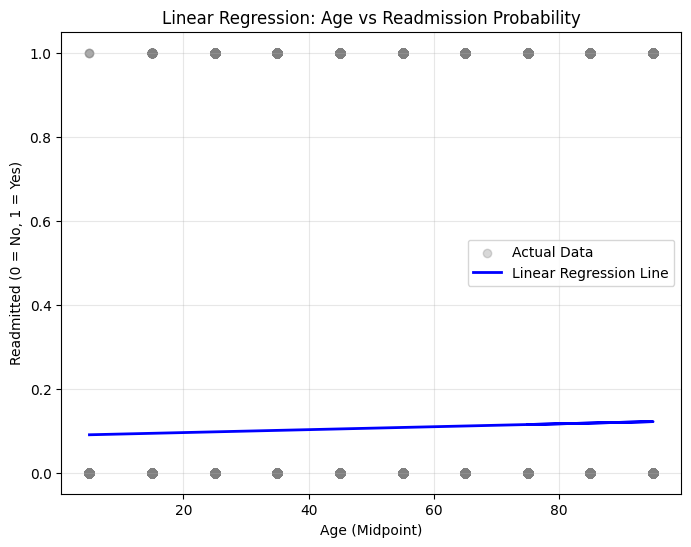

In [ ]:
#Import libraries
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare data 
# Using the full cleaned dataset (not just balanced training)
diabetes_cleaned = pd.read_csv('/workspaces/SP25-Project/data/diabetes_cleaned.csv')

# Remove any unknown gender values if needed
diabetes_cleaned = diabetes_cleaned[diabetes_cleaned['gender'] != 'Unknown/Invalid']

# Feature and Target
X_age = diabetes_cleaned[['age']]  # Important: double brackets to keep it as DataFrame
y_readmit = diabetes_cleaned['readmitted_binary']

# Fit Linear Regression 
linreg = LinearRegression()
linreg.fit(X_age, y_readmit)

# Print Coefficient and Intercept 
print(f"Intercept: {linreg.intercept_:.4f}")
print(f"Coefficient (Age effect): {linreg.coef_[0]:.4f}")

# Predict and Plot 
y_pred = linreg.predict(X_age)

plt.figure(figsize=(8,6))
plt.scatter(X_age, y_readmit, color='gray', alpha=0.3, label="Actual Data")
plt.plot(X_age, y_pred, color='blue', linewidth=2, label="Linear Regression Line")
plt.xlabel('Age (Midpoint)')
plt.ylabel('Readmitted (0 = No, 1 = Yes)')
plt.title('Linear Regression: Age vs Readmission Probability')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


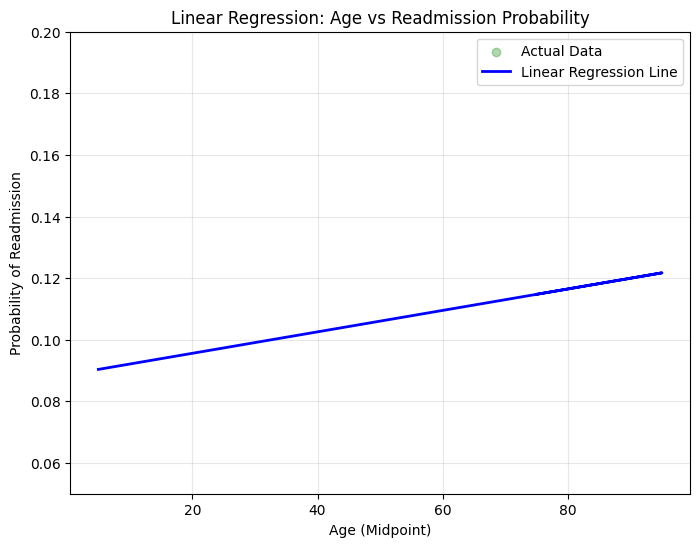

In [ ]:
# Predict and Plot (with better axis) 

y_pred = linreg.predict(X_age)

plt.figure(figsize=(8,6))
plt.scatter(X_age, y_readmit, color='green', alpha=0.3, label="Actual Data")
plt.plot(X_age, y_pred, color='blue', linewidth=2, label="Linear Regression Line")
plt.xlabel('Age (Midpoint)')
plt.ylabel('Probability of Readmission')
plt.title('Linear Regression: Age vs Readmission Probability')
plt.ylim(0.05, 0.20)  # <-- Fix the Y-axis to zoom into the range of probabilities
plt.legend()
plt.grid(alpha=0.3)
plt.show()
